In [1]:
# This line loads into iPython the libraries needed to generate 
# graphics in-line
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Birth Statistics Data ###

This notebook's goal is to study the question: *Are first-born babies more likely to arrive late?*

It is based on the book [Think Stats](http://www.greenteapress.com/thinkstats/)

#### Loading the data ####
The data we use is originally from NSFG (National Survey of Family Growth) and can also be downloaded from from [the data section of the Think Stats web site](http://www.greenteapress.com/thinkstats/nsfg.html).

The file that we use in this notebook is `2002FemPreg.dat`

As a first step we extract from the file `survey.py` (which is part of the [Think-Stats code examples zip file](http://www.greenteapress.com/thinkstats/thinkstats.code.zip)) a few lines that define the format of the file `2002FemPreg.dat`.

In [2]:
!head -2 ../data/ThinkStatsData/2002FemPreg.dat

           1 1     6 1     11093 1084     9 039 9   0  1 813             1093 13837                        1                5                                                                        116610931166 9201093                111             3    1   12  11         5391 110933316108432411211     2995 1212 69544441116122222 2 2224693215    000000000000000000000000000000000000003410.38939935294273869.3496019830486 6448.2711117047512 91231
           1 2     6 1     11166 1157     9 039 9   0  2 714             1166  6542112  2  05 1 4  5       51               1   41  4  201 20                                                        1166109311661093116611661231        111             3    1   14  11         5391 211663925115738501211 2 432 8701414 69544441116122222 2 2224693215    000000000000000000000000000000000000003410.38939935294273869.3496019830486 6448.2711117047512 91231


#### record format ###

The data consists of records, one record per line, each record corresponds to a single birth. The fields of the record are organized in a **Location specific** format, as defined below.

* **field:** The name of the attribute where the field will be stored. Most of the time I use the name from the NSFG codebook, converted to all lower case.
* **start:** The index of the starting column for this field. For example, the indices for caseid are 1–12.
* **end:** The index of the ending column for this field. Unlike in Python,the end index is inclusive.
* **conversion function:** A function that takes a string and converts it to an appropriate type. You can use built-in functions, like int and float, or user-defined functions. If the conversion fails, the attribute gets the string value ’NA’. If you don’t want to convert a field, you can provide an identity function or use str.


In [3]:
## This list of tuples defines the names and locations of the elements.
fields=[
    ('caseid', 1, 12, int),
    ('nbrnaliv', 22, 22, int),
    ('babysex', 56, 56, int),
    ('birthwgt_lb', 57, 58, int),
    ('birthwgt_oz', 59, 60, int),
    ('prglength', 275, 276, int),
    ('outcome', 277, 277, int),
    ('birthord', 278, 279, int),
    ('agepreg', 284, 287, int),
    ('finalwgt', 423, 440, float),
]

#### Description of the fields

* **caseid** is the integer ID of the respondent.
* **nbrnaliv** number of babies born together (twins, triplets etc.)
* **babysex** 1=male, 2=female
* **birthwgt_lb** weight of newborn (pounds)
* **birthwgt_oz** weight of newborn (ounces)
* **prglength** is the integer duration of the pregnancy in weeks.
* **outcome** is an integer code for the outcome of the pregnancy. The code 1 indicates a live birth.
 
* **birthord** is the integer birth order of each live birth; for example, the code for a first child is 1. For outcomes other than live birth, this field is blank.
* **agepreg** mother's age at pregnancy outcome (devide by 100 to get years)
* **finalwgt** is the statistical weight associated with the respondent. It is a floating- point value that indicates the number of people in the U.S. population this respondent represents. Members of oversampled groups have lower weights.


### read and parse data ###
In the next cell we read the file, parse it according to `fields`, and create a dictionary of lists, one for each field.

In [25]:
# columns is initialized as a dictionary
columns={}
# an empty list is created for each field
for (field, start, end, cast) in fields:
    columns[field]=[]
    
# The data is read from the file and inserted into the table.
file=open('../data/ThinkStatsData/2002FemPreg.dat','r')
for line in file.readlines():
    for (field, start, end, cast) in fields:
        try:
            s = line[start-1:end]
            val = cast(s)
        except ValueError:
            #print line
            #print field, start, end, s
            val = None
        columns[field].append(val)

#### Read into a Pandas Dataframe

In [26]:
import pandas
DF=pandas.DataFrame(data=columns)
print DF.shape
DF.head()

(13593, 10)


,agepreg,babysex,birthord,birthwgt_lb,birthwgt_oz,caseid,finalwgt,nbrnaliv,outcome,prglength
0,3316,1,1,8,13,1,6448.271112,1,1,39
1,3925,2,2,7,14,1,6448.271112,1,1,39
2,1433,1,1,9,2,2,12999.542264,3,1,39
3,1783,2,2,7,0,2,12999.542264,1,1,39
4,1833,2,3,6,3,2,12999.542264,1,1,39


### Cleaning up the weights field ###

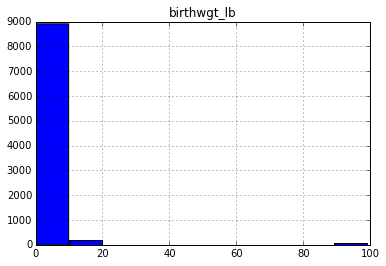

In [27]:
DF['birthwgt_lb'].hist()
title('birthwgt_lb')

We don't expect to see babies whose birth weight is > 90 Lb. Lets check these records out.

In [28]:
DF[DF['birthwgt_lb']>20].head()

,agepreg,babysex,birthord,birthwgt_lb,birthwgt_oz,caseid,finalwgt,nbrnaliv,outcome,prglength
126,2275,1,2,99,NaN,145,6131.419855,1,1,39
127,2875,1,3,99,NaN,145,6131.419855,1,1,39
129,3441,2,4,99,NaN,145,6131.419855,1,1,39
233,2658,1,1,99,NaN,252,10810.594955,1,1,40
234,2800,2,2,99,NaN,252,10810.594955,1,1,40


Clearly the ones with weight 99 pounds are cases for which the weight is not available.

Lets check on weights that are below 99 lb but above 20. It turns out there are only 3 such records, so we can safely ignore them.

In [29]:
selector=(DF['birthwgt_lb']>20) & (DF['birthwgt_lb']<99)
DF[selector].head()

,agepreg,babysex,birthord,birthwgt_lb,birthwgt_oz,caseid,finalwgt,nbrnaliv,outcome,prglength
5989,1891,7,2,97,97,5466,11139.342669,1,1,38
6069,1841,2,2,51,6,5540,21369.488468,1,1,39
12118,2041,2,1,98,98,11180,10663.726931,1,1,35


In [30]:
DF=DF[~selector]

It seems that these three cases are mistakes. It is safer to leave them out.

We therefor retain only the records with birth weight smaller than 20.
We also combine the lb and oz columns into a single weight column.

(13590, 11)

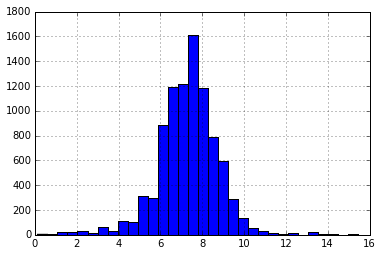

In [31]:
select=DF['birthwgt_lb']<20
#DF=DF[select]
DF['weight']=DF[select]['birthwgt_lb']+DF[select]['birthwgt_oz']/16
DF['weight'].hist(bins=32)
DF.shape

Now the distribution of weights looks close to Normal, so we are reasonably confident the these records are legit.

### Lets find out which fields tend to be undefined

In [32]:
anomalies=isnan(DF)  # anomalies is true (1) if 
                     # the corresponding DF entry is nan
print shape(anomalies),shape(DF)
sum(anomalies)

(13590, 11) (13590, 11)


agepreg         352
babysex        4449
birthord       4445
birthwgt_lb    4449
birthwgt_oz    4506
caseid            0
finalwgt          0
nbrnaliv       4445
outcome           0
prglength         0
weight         4506
dtype: int64

There seem to be about 4445 cases with about 6 undefined fields.

To make sure, lets see what is the outcome of the the pregnancy in those cases where >4 fields are not defined. Remember that outcome=1 indicates live birth, hopefully the normal outcome.


In [33]:
from collections import Counter
Counter(DF.ix[sum(anomalies,axis=1)>4,:]['outcome'])

Counter({2: 1862, 3: 120, 4: 1921, 5: 190, 6: 352})

Here are the codes for the outcome of the pregnancy

|  code  |  description  |
| ------ | ------------- |
| 1	     |  Live birth |
| 2	     |  Stillbirth |
| 3	     |  Miscarriage |
| 4	     |  Termination of Pregnancy less than 24 weeks |
| 5	     |  Termination of Pregnancy equal to or greater than 24 weeks |
| X	     |  Other including vanishing/papyraceous twin, or ectopic |


The records with a large number of undefined fields correspond to outcomes other than 1=live birth. It seems like they correspond to dead newborns of different types. We therefor remove them from the dataset.

We therefor keep only records where the outcome was 1=Live birth

In [34]:
DF=DF[DF['outcome']==1]
DF.shape

(9145, 11)

Finished cleaning the data, now back to the question: "Are first-born babies born later (after a longer pregnancy) ?"

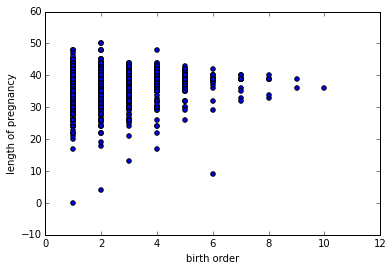

In [35]:
scatter(DF['birthord'],DF['prglength']);
xlabel('birth order');
ylabel('length of pregnancy');

From the scatter plot it seems that first borns have a larger variance in the length of pregnancy (both longer and shorter). But that might be an artifact of the fact that the number of instances is largest for the first born and decreasing with increasing birth order.

So lets try other visualizations.

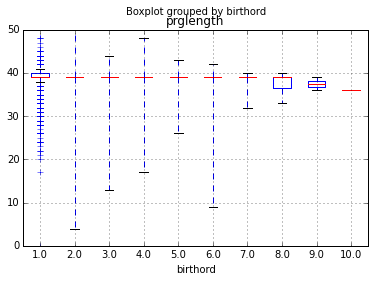

In [36]:
DF.boxplot(column='prglength',by='birthord')

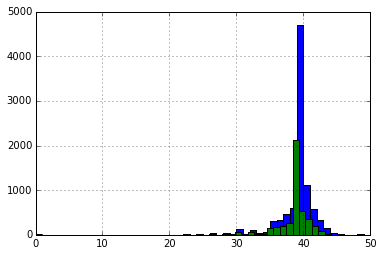

In [37]:
DF['prglength'].hist(bins=50);
DF[DF['birthord']==1]['prglength'].hist(bins=50);

It seems hard to make conclusions. In the histogram above the blue corresponds to the overall population, the green corresponds to the first born. There seems to be a slight tendency towards a **shorter** pregnancy for the first borns.

## How sure are we? Using statistical tests ##
We use the ttest statistic to decide whether the mean pregnancy length for he first-born is lower for the first pregnancy.

In [38]:
from scipy.stats import ttest_ind

D1 = DF['prglength']
D2 = DF[DF['birthord']==1]['prglength']
ttest_ind(D1,D2)


Ttest_indResult(statistic=-0.81487292926688992, pvalue=0.41515936644755669)

In [39]:
ttest_ind?

A p-value of 0.415 corresponds to no confidence (result could have been generated by chance alone with prob %41.5 .

## What did we learn?

We saw how to use python and pandas to analyze and clean up the data. We then saw how to use visualizations and statistical tests to answer the query.

In this case what we find is that, with this data, we **cannot** draw confident conclutions.

From a data-processing point of view this notebook is an example of:
1. iPython Notebooks.
1. Some simple python data structure and code.
1. Markdown.
1. Pandas and DataFrames.
